# UseCase C : Infer a knowledge Graph from a text (pdf, htlm, json, ect) & query

## Load dependencies

In [1]:
from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextContainer, LTChar
import re
from langchain.prompts.chat import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain.embeddings import DatabricksEmbeddings
from langchain_core.documents import Document
from langchain_community.graphs.networkx_graph import NetworkxEntityGraph
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio
from pyvis.network import Network
import networkx as nx
from networkx import NetworkXError
from langchain.chains import GraphQAChain
from langchain.llms import Databricks
from langchain_openai import ChatOpenAI
from langchain_ollama import OllamaEmbeddings
#from langchain_community.chains.graph_qa import GraphQAChain
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain_text_splitters import Language, RecursiveCharacterTextSplitter
import json
from pydantic import BaseModel
from typing import List, Union
import time
from datetime import datetime

def printDone():
    # Obtenir la date et l'heure actuelle
    maintenant = datetime.now()
    # Formater la date dans le format souhaité
    date_formatee = maintenant.strftime("DONE - %A %d %B à %Hh%M et %S secondes")
    # Retourner la date formatée
    return date_formatee

printDone()

'DONE - Wednesday 20 November à 17h06 et 51 secondes'

## Set global parameters

In [2]:
my_chunk_size = 800
my_chunk_overlap = 200

ollama_url = "http://ollama:11434/v1/"
ollama_embeddings = "http://ollama:11434/"

kg_LLM_name = 'llama3.2:3b'
kg_embeddings_LLM_name = 'nomic-embed-text'
my_kg_max_output_tokens = 4000

kg_embedding_size = 1024
qa_LLM_name = 'llama3.2:3b'
my_qa_max_output_tokens = 2000

my_similarity_threshold = 0.9 

path_currie = '/home/jovyan/work/dataset/currie_markdown.txt'

printDone()

'DONE - Wednesday 20 November à 17h06 et 51 secondes'

## Define treatment functions

### Raw text extraction

In [3]:
def load_markdown_file(source_dir):
    try:
        with open(source_dir, 'r', encoding='utf-8') as fichier:
            data = fichier.read()
        return data
    except FileNotFoundError:
        return "Le fichier n'a pas été trouvé."
    except Exception as e:
        return f"Une erreur s'est produite : {e}"

printDone()

'DONE - Wednesday 20 November à 17h06 et 51 secondes'

### Chunks creation

In [4]:
def split_markdown_into_chunks(markdown_text, target_dir, source, chunk_size=500, overlap=100):

  md_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.MARKDOWN, chunk_size=chunk_size, chunk_overlap=overlap
  )
  chunks_markdown = md_splitter.create_documents([markdown_text])
  for index, chunk in enumerate(chunks_markdown):
    chunk.metadata = {"source": source, "chunk_id": f"{index}"}

    for idx, chunk in enumerate(chunks_markdown):
        output_chunk_path = os.path.join(target_dir, f"chunk_{idx + 1:02d}_{source}.txt")
        with open(output_chunk_path, "w", encoding="utf-8") as f:
            f.write(chunk.page_content)

printDone()

'DONE - Wednesday 20 November à 17h06 et 51 secondes'

### Infere knowledge graph from chunks

In [5]:
def infer_knowledge_graph_from_chunks(llm, embedding, source_dir, target_dir, allowed_nodes=None, allowed_relationships=None, generate_embeddings=True):
    """
    Infère un Knowledge Graph à partir des chunks de texte extraits en utilisant Langchain et LLMGraphTransformer.
    :param source_dir: Répertoire source où se trouvent les fichiers de chunks de texte.
    :param target_dir: Répertoire cible où les fichiers du Knowledge Graph seront stockés.
    """

    class Node(BaseModel):
        source: str
        source_type: str
        relation: str
        target: str = "Unknown"  # Valeur par défaut
        target_type: str = "Unknown"  # Valeur par défaut
        source_embedding: Union[str, List[float]] = None
        source_type_embedding: Union[str, List[float]] = None
        target_embedding: Union[str, List[float]] = None
        target_type_embedding: Union[str, List[float]] = None
    
        def prepare_for_serialization(self):
            if isinstance(self.source_embedding, list):
                self.source_embedding = json.dumps(self.source_embedding)
            if isinstance(self.source_type_embedding, list):
                self.source_type_embedding = json.dumps(self.source_type_embedding)
            if isinstance(self.target_embedding, list):
                self.target_embedding = json.dumps(self.target_embedding)
            if isinstance(self.target_type_embedding, list):
                self.target_type_embedding = json.dumps(self.target_type_embedding)
    
    class GraphDocument(BaseModel):
        nodes: List[Node]
    
        def to_json(self):
            for node in self.nodes:
                node.prepare_for_serialization()
            return self.json()


    
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    print('LLMGraphTransformer created')
    
    for chunk_file in sorted(os.listdir(source_dir)):
        if chunk_file.endswith(".txt"):
            
            print(f".   Traitement de {chunk_file}")
            
            chunk_path = os.path.join(source_dir, chunk_file)
            with open(chunk_path, "r", encoding="utf-8") as f:
                chunk_text = f.read()

            messages = [
                SystemMessage(content=generate_system_knowledge_extraction_prompt()),
                HumanMessage(content=generate_human_knowledge_extraction_prompt(chunk_text)),
            ]
                
          #  llm_transformer = LLMGraphTransformer(
          #      llm=llm,
          #      prompt=messages,
          #      allowed_nodes=allowed_nodes,
          #      allowed_relationships=allowed_relationships,
          #      strict_mode=True,
          #      node_properties=True,
          #      relationship_properties=True
          #  )

            start_time = time.time()
            response = kg_llm.invoke(messages)
            end_time = time.time()
            execution_duration = end_time - start_time
            print(f".   La durée d'exécution LLM : {execution_duration:.1f} secondes.")
            
            response_text = response.content
            response_data = json.loads(response_text)
            
            #print("---")
            #print(response_data)
            #print("---")
            
            nodes = [Node(**item) for item in response_data]
            graph_documents = [GraphDocument(nodes=nodes)]
            
            # Créer un document à partir du chunk
            #document = Document(page_content=chunk_text)
            
            # Utiliser LLMGraphTransformer pour inférer des connaissances à partir du chunk
            #graph_documents = llm_transformer.convert_to_graph_documents([document])
            
            if generate_embeddings:
                # Générer les embeddings pour chaque nœud trouvé

                print(f".      Embeddings de {chunk_file}")
                
                # Définir les paramètres d'embedding pour DatabricksEmbeddings
                embeddings = embedding 

                start_time = time.time()
                for graph_doc in graph_documents:
                    for node in graph_doc.nodes:
                        node.source_embedding = embeddings.embed_query(node.source)
                        #node.source_type_embedding = embeddings.embed_query(node.source_type)
                        node.target_embedding = embeddings.embed_query(node.target)
                        #node.target_type_embedding = embeddings.embed_query(node.target_type)
                end_time = time.time()
                execution_duration = end_time - start_time
            else:
                for graph_doc in graph_documents:
                    for node in graph_doc.nodes:
                        node.source_embedding = None
                        node.source_type_embedding = None
                        node.target_embedding = None
                        node.target_type_embedding = None
                print(f".   La durée d'exécution embeddings : {execution_duration:.1f} secondes.")
            
            output_kg_path = os.path.join(target_dir, f"kg_{chunk_file}")
            
            # Enregistrer le Knowledge Graph sous forme de fichier JSON
            with open(output_kg_path, "w", encoding="utf-8") as f:
                full_graph_documents = [graph_doc.to_json() for graph_doc in graph_documents]
                f.write(json.dumps(full_graph_documents, indent=2))

    print(f"Traitement terminé")

printDone()

'DONE - Wednesday 20 November à 17h06 et 51 secondes'

In [6]:
def merge_knowledge_graph_files(source_dir, output_dir):
    """
    Lit les fichiers d'un répertoire source et fusionne le contenu en un seul fichier JSON bien formaté.
    :param source_dir: Répertoire source où se trouvent les fichiers Knowledge Graph à fusionner.
    :param output_dir: Répertoire cible où sera stocké le fichier fusionné.
    """
    merged_data = []

    # Parcourir tous les fichiers dans le répertoire source par ordre alphabétique croissant
    for file_name in sorted(os.listdir(source_dir)):
        if file_name.endswith(".txt") or file_name.startswith("kg_"):
            file_path = os.path.join(source_dir, file_name)
            
            # Lire le contenu du fichier JSON
            with open(file_path, "r", encoding="utf-8") as f:
                try:
                    # Le contenu du fichier est une liste contenant une chaîne JSON
                    content = f.read()
                    data_list = json.loads(content)  # Charger la liste de chaînes JSON
                    for data_str in data_list:
                        data = json.loads(data_str)  # Charger chaque chaîne JSON en tant qu'objet
                        # Ajouter les données du fichier au tableau fusionné
                        nodes = data.get("nodes", [])
                        if nodes:
                            merged_data.extend(nodes)
                except json.JSONDecodeError as e:
                    print(f"Erreur lors de la lecture de {file_name}: {e}")
                except TypeError as e:
                    print(f"Erreur de type lors de la lecture de {file_name}: {e}")

    # Générer le nom du fichier de sortie avec horodatage
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
    #output_file = os.path.join(output_dir, f"{timestamp}_compiled_knowledge_graph.txt")
    output_file = os.path.join(output_dir, f"compiled_knowledge_graph.txt")

    # Écrire les données fusionnées dans le fichier de sortie en tant qu'un seul objet JSON bien formaté
    if merged_data:  # S'assurer qu'il y a des données à écrire
        with open(output_file, "w", encoding="utf-8") as f:
            json.dump({"knowledge_graph": merged_data}, f, indent=2, ensure_ascii=False)
        print(f"Fusion terminée. Données enregistrées dans {output_file}")
    else:
        print("Aucune donnée à fusionner. Aucun fichier de sortie créé.")

printDone()

'DONE - Wednesday 20 November à 17h06 et 51 secondes'

### Load KG data in graph

In [7]:
def load_knowledge_graph_to_networkx(merged_file):
    """
    Charge le fichier fusionné dans un graphe de type NetworkxEntityGraph.
    :param merged_file: Chemin du fichier Knowledge Graph fusionné.
    :return: Graph NetworkX à utiliser.
    """
    G = nx.DiGraph()  # Utiliser un graphe orienté pour représenter les relations entre entités

    # Charger le fichier Knowledge Graph fusionné
    with open(merged_file, "r", encoding="utf-8") as f:
        try:
            data = json.load(f)
            nodes = data.get("knowledge_graph", [])
            
            # Ajouter les noeuds et liens au graphe NetworkX
            for node in nodes:
                source = node.get("source")
                source_type = node.get("source_type")
                source_embedding = node.get("source_embedding")
                target = node.get("target")
                target_type = node.get("target_type")
                target_embedding = node.get("target_embedding")
                relation = node.get("relation")

                # Vérifier que source et target sont définis avant de les ajouter
                if source and target:
                    # Ajouter les noeuds avec leurs attributs
                    if not G.has_node(source):
                        G.add_node(source, type=source_type, embedding=eval(source_embedding) if source_embedding else None)
                    if not G.has_node(target):
                        G.add_node(target, type=target_type, embedding=eval(target_embedding) if target_embedding else None)

                    # Ajouter un lien (arête) entre source et target avec la relation comme attribut
                    G.add_edge(source, target, relation=relation)

        except json.JSONDecodeError as e:
            print(f"Erreur lors du chargement du fichier Knowledge Graph: {e}")
    
    return G

printDone()

'DONE - Wednesday 20 November à 17h06 et 51 secondes'

In [8]:
def merge_duplicate_nodes_using_embeddings(graph, similarity_threshold=0.9):
    """
    Fusionne les nœuds en doublon en utilisant des embeddings et la similarité cosinus.
    :param graph: Graphe NetworkX à utiliser.
    :param similarity_threshold: Seuil de similarité pour identifier les doublons.
    :return: Tuple contenant le graphe NetworkX après fusion des doublons et la liste des fusions effectuées.
    """
    nodes = list(graph.nodes(data=True))
    embeddings = [data['embedding'] for _, data in nodes if 'embedding' in data and data['embedding'] is not None]
    node_ids = [node_id for node_id, data in nodes if 'embedding' in data and data['embedding'] is not None]

    if len(embeddings) < 2:
        return graph, []  # Pas assez de nœuds avec des embeddings pour fusionner

    embeddings_matrix = np.array(embeddings)
    similarity_matrix = cosine_similarity(embeddings_matrix)

    merged_nodes = set()
    merge_details = []  # Liste pour stocker les détails des fusions

    for i in range(len(node_ids)):
        for j in range(i + 1, len(node_ids)):
            if similarity_matrix[i][j] > similarity_threshold and node_ids[j] not in merged_nodes:
                # Fusionner node i et node j
                node_a_id = node_ids[i]
                node_b_id = node_ids[j]

                # Enregistrer les détails de la fusion
                merge_details.append({
                    'node_a': node_a_id,
                    'node_b': node_b_id,
                    'similarity': similarity_matrix[i][j],
                    'relations_transferred_from_b_to_a': {
                        'predecessors': list(graph.predecessors(node_b_id)),
                        'successors': list(graph.successors(node_b_id))
                    }
                })

                # Transférer les relations de node_b à node_a
                for predecessor in list(graph.predecessors(node_b_id)):
                    graph.add_edge(predecessor, node_a_id, **graph.get_edge_data(predecessor, node_b_id))

                for successor in list(graph.successors(node_b_id)):
                    graph.add_edge(node_a_id, successor, **graph.get_edge_data(node_b_id, successor))

                # Supprimer le nœud dupliqué
                graph.remove_node(node_b_id)
                merged_nodes.add(node_b_id)

    return graph, merge_details

printDone()

'DONE - Wednesday 20 November à 17h06 et 51 secondes'

### Load final KG data 

In [9]:
def load_final_knowledge_graph(directory_path):
    """
    Charge les fichiers Knowledge Graph sauvegardés dans un graph NetworkxEntityGraph et enregistre le graph final.
    :param target_dir: Répertoire cible où les fichiers du Knowledge Graph sont stockés.
    :param output_dir: Répertoire où le graph final sera enregistré.
    :return: Graph NetworkxEntityGraph avec les noeuds et les relations ajoutés.
    """
    class NetworkxEntityGraph:
        def __init__(self):
            self._graph = nx.DiGraph()
    
        def add_node(self, node_id, **attrs):
            self._graph.add_node(node_id, **attrs)
    
        def add_edge(self, source, target, **attrs):
            self._graph.add_edge(source, target, **attrs)

    graph = NetworkxEntityGraph()
    
    for kg_file in os.listdir(target_dir):
        if kg_file.endswith(".json"):
            kg_path = os.path.join(target_dir, kg_file)
            with open(kg_path, "r", encoding="utf-8") as f:
                graph_document = Document.from_json(f.read())
                
                # Ajouter les noeuds au graph
                for node in graph_document.nodes:
                    print(f"Ajout du nœud : {node.id}")
                    graph.add_node(node.id, **node.__dict__)
                
                # Ajouter les relations au graph
                for edge in graph_document.relationships:
                    print(f"Ajout de la relation : {edge.source.id} -> {edge.target.id}")
                    graph._graph.add_edge(
                        edge.source.id,
                        edge.target.id,
                        **edge.__dict__
                    )
    
    # Enregistrer le graph final dans un fichier JSON
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
    output_file_path = os.path.join(output_dir, f"{current_time}_final_knowledge_graph.json")
    with open(output_file_path, "w", encoding="utf-8") as f:
        graph_data = {
            "nodes": [{"id": node, **data} for node, data in graph._graph.nodes(data=True)],
            "edges": [{"source": u, "target": v, **data} for u, v, data in graph._graph.edges(data=True)]
        }
        json.dump(graph_data, f, ensure_ascii=False, indent=4)
    
    return graph

printDone()

'DONE - Wednesday 20 November à 17h06 et 51 secondes'

### Get KG schema

In [10]:
def get_graph_schema(graph):
    """
    Renvoie le schéma du graph NetworkxEntityGraph.
    :param graph: Graph NetworkxEntityGraph chargé.
    :return: Dictionnaire contenant les types de noeuds et de relations.
    """
    schema = {
        "nodes": set(),
        "relationships": set()
    }
    
    # Obtenir les types de noeuds
    for _, data in graph._graph.nodes(data=True):
        schema["nodes"].add(data.get("type", "Unknown"))
    
    # Obtenir les types de relations
    for _, _, data in graph._graph.edges(data=True):
        schema["relationships"].add(data.get("relation", "Unknown"))
    
    return {
        "nodes": list(schema["nodes"]),
        "relationships": list(schema["relationships"])
    }

printDone()

'DONE - Wednesday 20 November à 17h06 et 51 secondes'

### Define GraphQAChain 

In [11]:
def create_graph_qa_chain(graph, qa_llm):
    """
    Crée une GraphQAChain pour interagir avec le Knowledge Graph.
    :param graph: Graph NetworkxEntityGraph chargé.
    :param llm: Modèle LLM à utiliser pour la chaîne QA.
    :return: Instance de GraphQAChain.
    """
    chain = GraphQAChain.from_llm(
        llm=qa_llm,
        graph=graph,
        verbose=True
    )
    return chain

printDone()

'DONE - Wednesday 20 November à 17h06 et 51 secondes'

### Use GraphQAChain

In [12]:
def run_query_on_graph(chain, question):
    """
    Pose une question en utilisant la GraphQAChain et renvoie la réponse.
    :param chain: Instance de GraphQAChain.
    :param question: Question à poser.
    :return: Réponse à la question.
    """
    return chain.invoke(question)

printDone()

'DONE - Wednesday 20 November à 17h06 et 51 secondes'

In [13]:
def display_graph(graph):
    """
    Affiche le graphe en utilisant Matplotlib pour permettre un affichage interactif.
    :param graph: Graphe NetworkX à afficher.
    """
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(graph)  # Positionnement des nœuds pour l'affichage
    nx.draw(graph, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')
    edge_labels = nx.get_edge_attributes(graph, 'relation')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)
    plt.title("Knowledge Graph")
    plt.show()

printDone()

'DONE - Wednesday 20 November à 17h06 et 52 secondes'

## Usage

### Configure folders

In [14]:
dossier_source = "/home/jovyan/work/rag/01_data_source"
dossier_raw_data = "/home/jovyan/work/rag/02_raw_data"
dossier_chunk = "/home/jovyan/work/rag/03_chunks"
dossier_kg = "/home/jovyan/work/rag/04_kg"
dossier_compil = "/home/jovyan/work/rag/05_compil/"
dossier_merge = "/home/jovyan/work/rag/06_merge"

if not os.path.exists(dossier_source):
    os.makedirs(dossier_source)

if not os.path.exists(dossier_raw_data):
    os.makedirs(dossier_raw_data)

if not os.path.exists(dossier_chunk):
    os.makedirs(dossier_chunk)

if not os.path.exists(dossier_kg):
    os.makedirs(dossier_kg)

if not os.path.exists(dossier_compil):
    os.makedirs(dossier_compil)

if not os.path.exists(dossier_merge):
    os.makedirs(dossier_merge)

printDone()

'DONE - Wednesday 20 November à 17h06 et 52 secondes'

### Load markdown source text file

In [15]:
markdown_text = load_markdown_file('/home/jovyan/work/rag/02_raw_data/currie_markdown.txt')

printDone()

'DONE - Wednesday 20 November à 17h06 et 52 secondes'

## Create chunks

In [16]:
# Diviser les fichiers texte extraits en chunks et les stocker dans chunk
split_markdown_into_chunks(markdown_text, dossier_chunk, 'currie', chunk_size=my_chunk_size, overlap=my_chunk_overlap)

printDone()

'DONE - Wednesday 20 November à 17h06 et 52 secondes'

### Configure LLM for KG inference

# Configuration du LLM pour Databricks or Ollama

In [17]:
# kg_llm = Databricks(max_output_tokens=my_kg_max_output_tokens, model_name=kg_LLM_name)

kg_llm = ChatOpenAI(api_key="ollama", base_url=ollama_url, model_name=kg_LLM_name, temperature=0.1, verbose=True)

printDone()

'DONE - Wednesday 20 November à 17h06 et 52 secondes'

In [18]:
#embedding_params = {
#    'model_name': kg_embeddings_LLM_name,
#    'embedding_size': kg_embedding_size
#}
#kg_embeddings_engin = DatabricksEmbeddings(embedding_params)

kg_embeddings_engin = OllamaEmbeddings(base_url=ollama_embeddings, model=kg_embeddings_LLM_name)

printDone()

'DONE - Wednesday 20 November à 17h06 et 52 secondes'

### Infere KG from chunks

In [19]:
#my_allowed_nodes=['Person', 'Organization']

In [20]:
#my_allowed_relationships=['works_at', 'founded_by']

In [21]:
def generate_system_knowledge_extraction_prompt():
    prompt = """
    # Knowledge Graph Extraction Instructions
    
    ## 1. Overview
    
    You are an expert algorithm designed for extracting information in structured formats to build a **knowledge graph**. 
    
    - **Entities (Nodes)** represent people, places, organizations, concepts, etc.
      in case of **Entities (Nodes)** represent people (but can be extended to other entity type), try to infer both name and forename in order to increase accuracy of information 
    - **Relationships (Edges)** represent the connections or associations between entities.
    
    Your goal is to capture as much information from the text as possible **without sacrificing accuracy**. 
    Do **not** add any information that is not explicitly mentioned in the text.
    
    The aim is to achieve **simplicity and clarity** in the knowledge graph, making it accessible for a vast audience.
    
    ## 2. Guidelines for Labeling Entities and Relationships
    
    ### **Entities:**
    
    - **Consistency:** Use basic or elementary types for entity labels. Ensure you use available types for node labels.
    - **Example:** When identifying a person, always label them as **"Person"**. Avoid more specific terms like "Mathematician" or "Scientist".
    - **Entity IDs:** Do **not** use integers as entity IDs. Entity IDs should be names or human-readable identifiers found in the text.
    - **date:** Entity identified by a date (in any format) a name shall have the "Entity Type" : "Date"
    
    ### **Relationships:**
    
    - **Generality:** Use general and timeless relationship types instead of specific or momentary ones.
      - **Example:** Instead of "BECAME_PROFESSOR", use "PROFESSOR_OF".
    - **Consistency:** Ensure consistency and generality in relationship types when constructing the knowledge graph.
    
    ## 3. Coreference Resolution
    
    - **Maintain Entity Consistency:** If an entity is mentioned multiple times in the text using different names or pronouns (e.g., "John Doe", "John", "he"), always use the most complete identifier throughout the knowledge graph.
      - **Example:** Use "John Doe" as the entity ID in all instances.
    - This ensures the knowledge graph is coherent and easily understandable.
    
    ## 4. Output Format

    - Represent the extracted information as a **list of triples** in the format **(head, predicate, tail)**.
    - Provide the output in **JSON format** as follows:

    [
      {
        "source": "Subject Entity",
        "source_type": "Entity Type",
        "relation": "Relationship Type",
        "target": "Object Entity",
        "target_type": "Entity Type"
      },
      ...
    ]
    
    ## 4. Output Format check

    Ensure that, for each triples, all checks below are compliant 
    - "source" is existing
    - "source" is not empty or null
    - "source_type" is existing 
    - "source_type" is not empty or null
    - "relation" is existing 
    - "relation" is not empty or null 
    - "target" is existing
    - "target" is not empty or null
    - "target_type" is existing
    - "target_type" is not empty or null

    if a target is empty, review the relation description and the source text in order to infer the target
    by example the ("relation" : "DISCOVERED_RADIUM_POLONIUM") can be transformed in [("relation" : "DISCOVER", "target" : "RADIUM"), ("relation" : "DISCOVER", "target" : "POLONIUM")]
    
    ## 6. Examples

    Below are some examples to guide you:

    ### **Example 1:**

    **Text:**

    "Adam is a software engineer at Microsoft since 2009, and last year he got an award as the Best Talent."

    **Extracted Triples:**

    [
      {
        "source": "Adam",
        "source_type": "Person",
        "relation": "WORKS_FOR",
        "target": "Microsoft",
        "target_type": "Company"
      },
      {
        "source": "Adam",
        "source_type": "Person",
        "relation": "HAS_AWARD",
        "target": "Best Talent",
        "target_type": "Award"
      }
    ]

    ### **Example 2:**

    **Text:**

    "Microsoft is a tech company that provides several products such as Microsoft Word."

    **Extracted Triples:**

    [
      {
        "source": "Microsoft",
        "source_type": "Company",
        "relation": "PROVIDES_PRODUCT",
        "target": "Microsoft Word",
        "target_type": "Product"
      }
    ]

    ### **Example 3:**

    **Text:**

    "Microsoft Word is a lightweight app that is accessible offline."
  
    **Extracted Triples:**

   [
      {
        "source": "Microsoft Word",
        "source_type": "Product",
        "relation": "HAS_CHARACTERISTIC",
        "target": "lightweight app",
        "target_type": "Characteristic"
      },
      {
        "source": "Microsoft Word",
        "source_type": "Product",
        "relation": "HAS_CHARACTERISTIC",
        "target": "accessible offline",
        "target_type": "Characteristic"
      }
    ]
    
    
    """
    return prompt

printDone()

'DONE - Wednesday 20 November à 17h06 et 52 secondes'

In [22]:
def generate_human_knowledge_extraction_prompt(chunk):
    prompt = f"""
    Now, by applying "Knowledge Graph Extraction Instructions", extract entities and relationships from the text :
    \"\"\"
    {chunk}
    \"\"\"
    Reminder: Make sure to answer in the correct format and do not include any explanations. Make sure to have for each **Extracted Triples**: source, source_type, relation, target, target_type
    """
    return prompt

printDone()

'DONE - Wednesday 20 November à 17h06 et 52 secondes'

In [23]:
# Inférer le Knowledge Graph à partir des chunks de texte et le stocker dans knowledge_graph
infer_knowledge_graph_from_chunks(kg_llm, kg_embeddings_engin, dossier_chunk, dossier_kg,generate_embeddings=True)

printDone()

LLMGraphTransformer created
.   Traitement de chunk_01_currie.txt
.   La durée d'exécution LLM : 153.6 secondes.
.      Embeddings de chunk_01_currie.txt
.   Traitement de chunk_02_currie.txt
.   La durée d'exécution LLM : 50.3 secondes.
.      Embeddings de chunk_02_currie.txt
.   Traitement de chunk_03_currie.txt
.   La durée d'exécution LLM : 84.9 secondes.
.      Embeddings de chunk_03_currie.txt
.   Traitement de chunk_04_currie.txt
.   La durée d'exécution LLM : 63.1 secondes.
.      Embeddings de chunk_04_currie.txt
.   Traitement de chunk_05_currie.txt
.   La durée d'exécution LLM : 77.2 secondes.
.      Embeddings de chunk_05_currie.txt
.   Traitement de chunk_06_currie.txt
.   La durée d'exécution LLM : 58.5 secondes.
.      Embeddings de chunk_06_currie.txt
.   Traitement de chunk_07_currie.txt
.   La durée d'exécution LLM : 69.7 secondes.
.      Embeddings de chunk_07_currie.txt
.   Traitement de chunk_08_currie.txt
.   La durée d'exécution LLM : 62.9 secondes.
.      Embed

'DONE - Wednesday 20 November à 17h20 et 10 secondes'

### Load KG data in final graph

In [24]:
merge_knowledge_graph_files(dossier_kg, dossier_compil)

printDone()

Fusion terminée. Données enregistrées dans /home/jovyan/work/rag/05_compil/compiled_knowledge_graph.txt


'DONE - Wednesday 20 November à 17h20 et 10 secondes'

### Merge duplicated nodes in graph

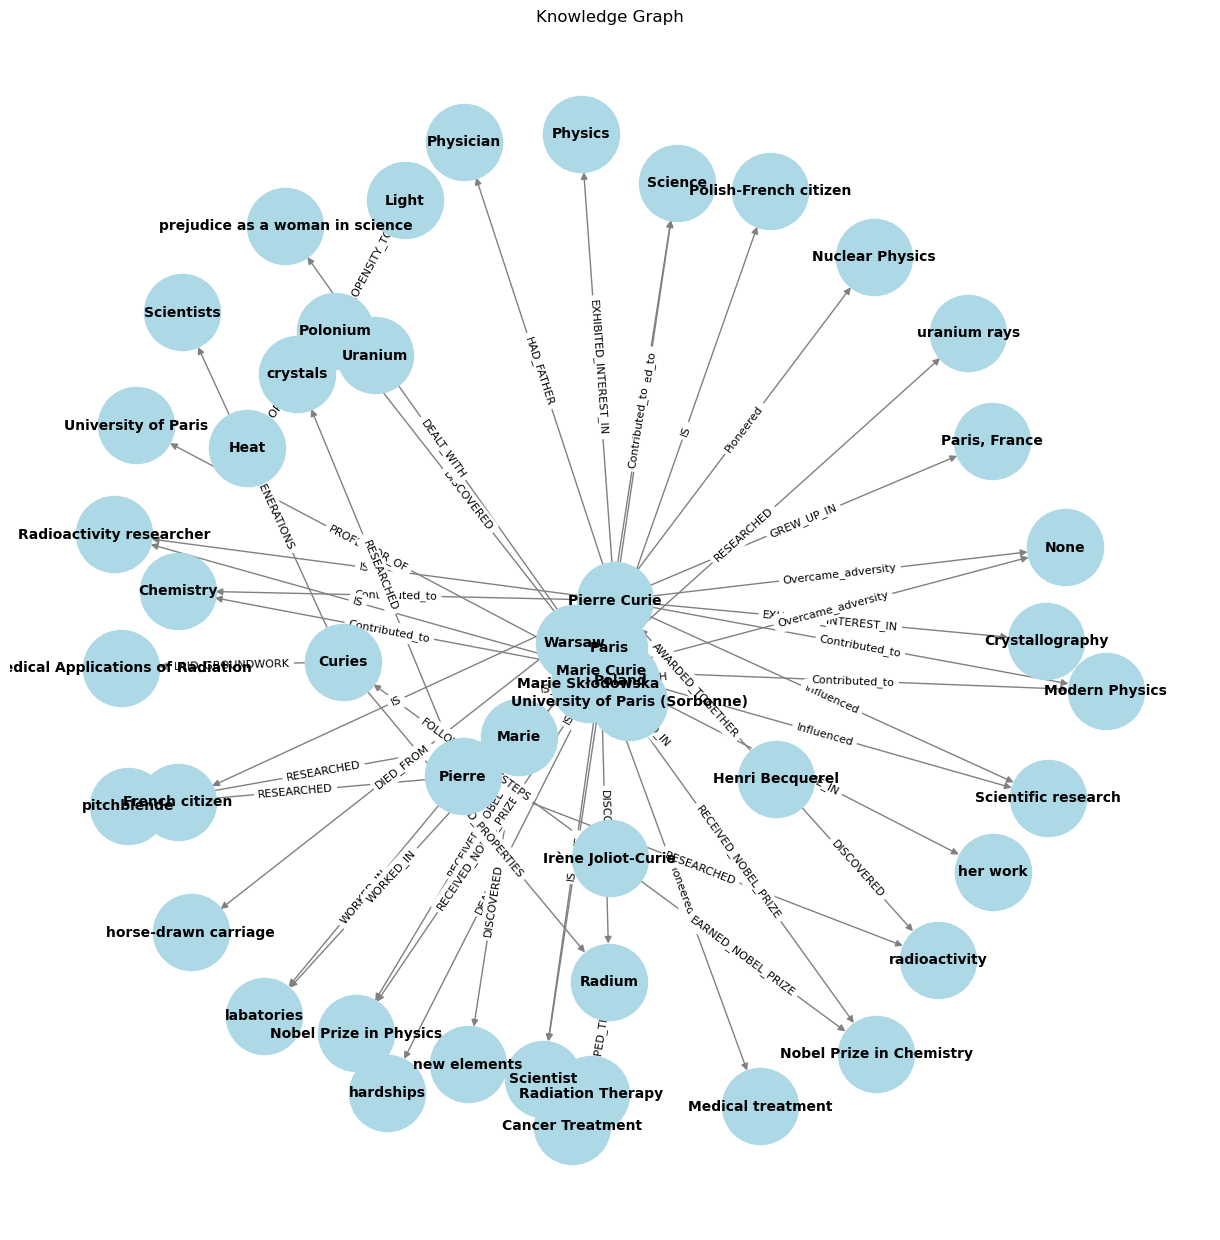

'DONE - Wednesday 20 November à 17h20 et 12 secondes'

In [25]:
# Charger les fichiers Knowledge Graph dans un graph NetworkxEntityGraph
graph = load_knowledge_graph_to_networkx('/home/jovyan/work/rag/05_compil/compiled_knowledge_graph.txt')
display_graph(graph)

printDone()

### Load final KG data in graph for use

Fusion de Scientists dans Scientist
    Similarité : 0.9449810384980342
    Relations transférées de Scientists vers Scientist:
      Prédécesseurs : ['Curies']
      Successeurs : []
Fusion de University of Paris dans University of Paris (Sorbonne)
    Similarité : 0.9216579755087229
    Relations transférées de University of Paris vers University of Paris (Sorbonne):
      Prédécesseurs : ['Marie Curie']
      Successeurs : []

Nombre total de fusions effectuées : 2


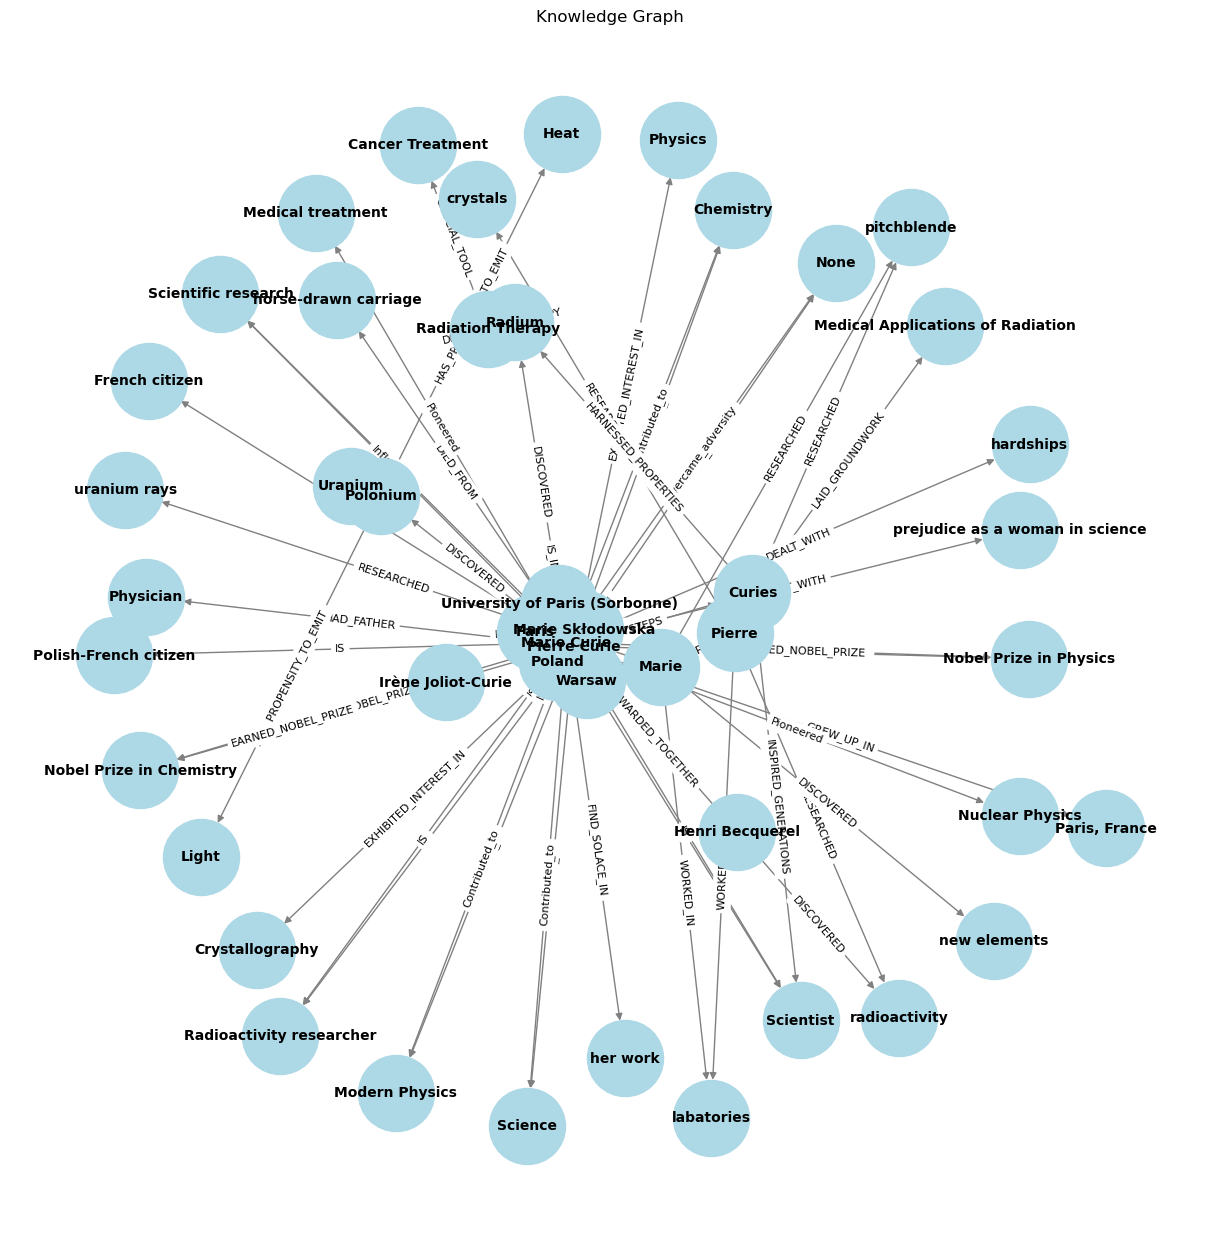

'DONE - Wednesday 20 November à 17h20 et 13 secondes'

In [26]:
graph2, simplifications = merge_duplicate_nodes_using_embeddings(graph)

# Afficher les détails des simplifications
for simplification in simplifications:
    print(f"Fusion de {simplification['node_b']} dans {simplification['node_a']}")
    print(f"    Similarité : {simplification['similarity']}")
    print(f"    Relations transférées de {simplification['node_b']} vers {simplification['node_a']}:")
    print(f"      Prédécesseurs : {simplification['relations_transferred_from_b_to_a']['predecessors']}")
    print(f"      Successeurs : {simplification['relations_transferred_from_b_to_a']['successors']}")

# Afficher le nombre total de fusions effectuées
print(f"\nNombre total de fusions effectuées : {len(simplifications)}")

display_graph(graph2)

printDone()

### Configure LLM for GraphQAChain

In [27]:
# Utiliser un autre LLM  pour la GraphQAChain
#qa_llm = Databricks(max_output_tokens= my_qa_max_output_tokens, model_name=qa_LLM_name)

qa_llm = ChatOpenAI(api_key="ollama", base_url=ollama_url, model_name=kg_LLM_name, temperature=0.1, verbose=True)

printDone()

'DONE - Wednesday 20 November à 17h20 et 13 secondes'

### Create GraphQAChain

In [28]:
entity_graph = NetworkxEntityGraph(graph2)
#qa_chain = create_graph_qa_chain(graph2, qa_llm)

qa_chain = GraphQAChain.from_llm(
    llm=qa_llm,
    graph=entity_graph,
    verbose=True
)

printDone()

'DONE - Wednesday 20 November à 17h20 et 13 secondes'

### Use GraphQAChain

In [29]:
# Poser une question en utilisant la GraphQAChain
question = "Who is Marie Curie?"
response = run_query_on_graph(qa_chain, question)
print(response["result"])

printDone()



> Entering new GraphQAChain chain...
Entities Extracted:
Marie Curie
Full Context:
Marie Curie IS Scientist
Marie Curie IS Radioactivity researcher
Marie Curie IS Polish-French citizen
Marie Curie LIVES_IN Warsaw
Marie Curie PROFESSOR_OF University of Paris (Sorbonne)
Marie Curie DISCOVERED Polonium
Marie Curie RECEIVED_NOBEL_PRIZE Nobel Prize in Physics
Marie Curie RECEIVED_NOBEL_PRIZE Nobel Prize in Chemistry
Marie Curie DISCOVERED Radium
Marie Curie DEALT_WITH prejudice as a woman in science
Marie Curie DEALT_WITH hardships
Marie Curie FIND_SOLACE_IN her work
Marie Curie Contributed_to Science
Marie Curie Contributed_to Modern Physics
Marie Curie Contributed_to Chemistry
Marie Curie Overcame_adversity None
Marie Curie Influenced Scientific research
Marie Curie Pioneered Medical treatment

> Finished chain.
Marie Curie was a Scientist, Radioactivity researcher, Polish-French citizen, and Professor at the University of Paris (Sorbonne). She made significant contributions to Science,

'DONE - Wednesday 20 November à 17h21 et 03 secondes'